In [151]:
import cv2
import matplotlib.pyplot as plt
from flattener import flattener
from match_template import match_template, templates
import numpy as np

In [152]:
def imshow(img, ax=None, cmap='gray'):
    if ax is None:
        plt.figure(figsize=(10, 10))
        ax = plt
    ax.imshow(img, cmap=cmap)
    ax.axis('off')

In [153]:
CARD_MIN_AREA = 50_000

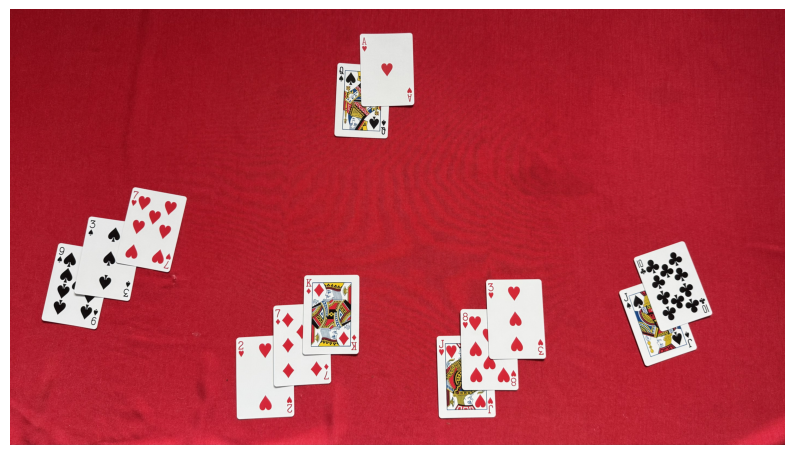

In [154]:
image_path = "database/IMG_2566.jpeg"  # Path to your uploaded image
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
imshow(image, cmap=None)

segmentation_presentation = image.copy()

In [155]:
bounding_rects = []

In [156]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(gray)
blur = cv2.GaussianBlur(clahe, (21, 21), 0)
_, thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

for contour in contours:
    area = cv2.contourArea(contour)
    if area < CARD_MIN_AREA:
        break
    cv2.drawContours(segmentation_presentation, [contour], 0, (0, 255, 0), 22)
    
    bounding_rects.append((*cv2.boundingRect(contour), contour))

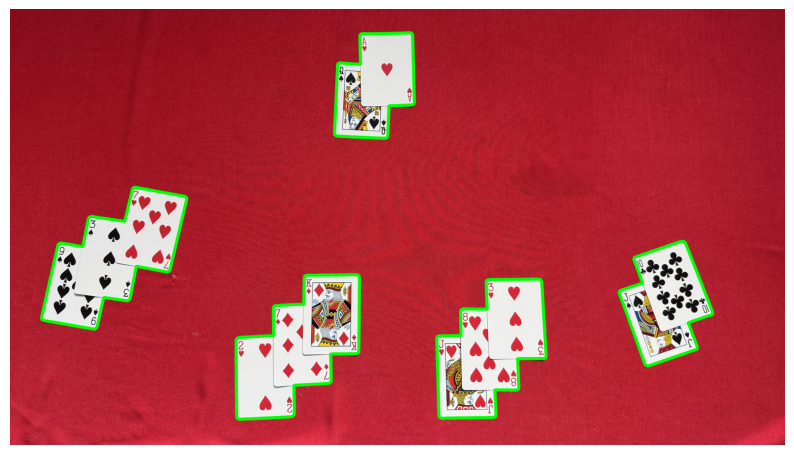

In [157]:
imshow(segmentation_presentation)

In [158]:
def get_cropped_pile_image(image, bounding_rect):
    x, y, w, h, c = bounding_rect
    
    mask = np.zeros_like(image)
    cv2.drawContours(mask, [c], -1, (255, 255, 255), thickness=cv2.FILLED)
    masked_image = cv2.bitwise_and(image, mask)
    cropped_image = masked_image[y:y+h, x:x+w]
    
    return cropped_image

In [159]:
def classify(image, box) -> (str, int, int):
    x, y, w, h = cv2.boundingRect(box)
            
    peri = cv2.arcLength(box,True)
    approx = cv2.approxPolyDP(box,0.01*peri,True)
    pts = np.float32(approx)
    
    flattened_card = flattener(image, pts, w, h)
    
    corner = flattened_card[0:84, 0:32]
    corner_zoom = cv2.resize(corner, (0,0), fx=4, fy=4)
    corner_blur = cv2.GaussianBlur(corner_zoom,(5,5),0)
    retval, corner_thresh = cv2.threshold(corner_blur, 155, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    matches = sorted([[name, *match_template(corner_thresh, template)] for name, template in templates.items()], key=lambda x: x[1], reverse=True)
    
    if matches[0][1] > .5:
        return matches[0][0], x, y
    
    flattened_card = cv2.flip(flattened_card, 1)
    
    corner = flattened_card[0:84, 0:32]
    corner_zoom = cv2.resize(corner, (0,0), fx=4, fy=4)
    corner_blur = cv2.GaussianBlur(corner_zoom,(5,5),0)
    retval, corner_thresh = cv2.threshold(corner_blur, 155, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    matches = sorted([[name, *match_template(corner_thresh, template)] for name, template in templates.items()], key=lambda x: x[1], reverse=True)
        
    return matches[0][0], x, y

In [160]:
for bounding_rect in bounding_rects:
    cropped_pile = get_cropped_pile_image(clahe, bounding_rect)
    
    X, Y, *_ = bounding_rect
    
    _, cropped_thresh = cv2.threshold(cropped_pile,220,255,cv2.THRESH_BINARY)
    cropped_eroded = cv2.erode(cropped_thresh, np.ones((5, 5), np.uint8))
    
    contours, _ = cv2.findContours(cropped_eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < CARD_MIN_AREA // 2: # Up to half of the card can be covered by other card
            break
        
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int32(box)
        
        name, label_x, label_y = classify(get_cropped_pile_image(image, bounding_rect), box)
        cv2.putText(segmentation_presentation, name, (X + label_x, Y + label_y), 0, 5., (0, 0, 0), 11)
        
        cv2.drawContours(segmentation_presentation, [box + [X, Y]], -1, (0, 0, 255), thickness=11)

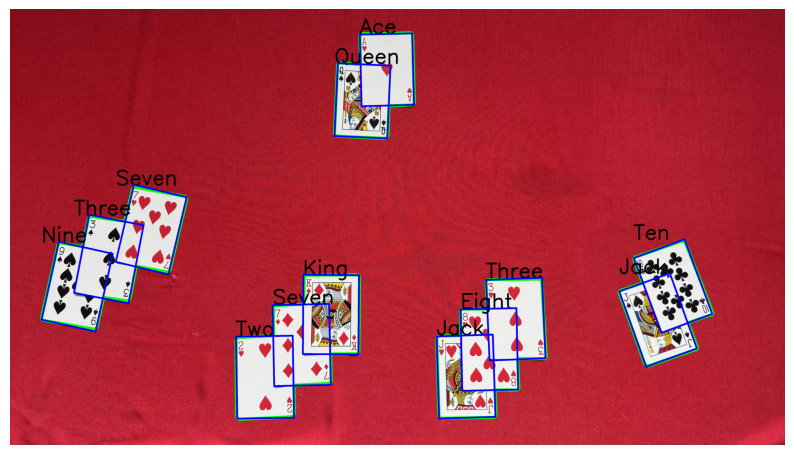

In [161]:
imshow(segmentation_presentation)